In [1]:
#compressai is a library for end-to-end compression research with PyTorch
from compressai.entropy_models import EntropyBottleneck, GaussianConditional #EntropyBottleneck is a module that implements a generic entropy model
#GuassianConditional is a module that implements a Gaussian conditional entropy model
from compressai.ans import BufferedRansEncoder, RansDecoder#BufferedRansEncoder is a module that implements a buffered RANs encoder
from compressai.models import CompressionModel#CompressionModel is a base class for compression models
from compressai.layers import (
    AttentionBlock,
    ResidualBlock,#create a residual block
    ResidualBlockUpsample,
    ResidualBlockWithStride,
    conv3x3,#create a 3x3 convolutional layer
    subpel_conv3x3,#create a sub-pixel convolutional layer(when we want to upsample the image,want to increase the resolution of the image)
)

import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch
#einops is a library for deep learning with PyTorch, TensorFlow, JAX, and NumPy
from einops import rearrange #rearrange is a function that rearranges the dimensions of a tensor
from einops.layers.torch import Rearrange #Rearrange class can be a layer in a neural network

from timm.models.layers import trunc_normal_, DropPath#timm is a deep learning library for PyTorch
#trunc_normal_ is a function that initializes the weights of a tensor with a truncated normal distribution
#DropPath is a class that implements the drop path regularization technique
import numpy as np
import math
#import argparse
import random
import sys
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms#transforms is a module that provides common image transformations

from compressai.datasets import ImageFolder
from compressai.zoo import models
from pytorch_msssim import ms_ssim

from torch.utils.tensorboard import SummaryWriter #SummaryWriter is a class that writes entries directly to event files
import os

#define global variables
SCALES_MIN = 0.11
SCALES_MAX = 256 
SCALES_LEVELS = 64
def conv1x1(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:#create a 1x1 convolutional layer
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)#nn.Conv2d is a class that implements a 2D convolutional layer
    #in_ch is the number of input channels,out_ch is the number of output channels,stride is the step size of the convolutional layer
    #convolution kernel size is 1x1

def get_scale_table(min=SCALES_MIN, max=SCALES_MAX, levels=SCALES_LEVELS):
    return torch.exp(torch.linspace(math.log(min), math.log(max), levels))
    #torch.exp is a function that returns the exponential of the input tensor,this is a scale table

def ste_round(x: Tensor) -> Tensor:
    """
    Straight-Through Estimator (STE) is a technique used to approximate the gradient of a non-differentiable function
    """
    return torch.round(x) - x.detach() + x

def find_named_module(module, query):
    """Helper function to find a named module. Returns a `nn.Module` or `None`
    Args:
        module (nn.Module): the root module
        query (str): the module name to find
    Returns:
        nn.Module or None
    """
    return next((m for n, m in module.named_modules() if n == query), None)

def find_named_buffer(module, query):
    """Helper function to find a named buffer. Returns a `torch.Tensor` or `None`

    Args:
        module (nn.Module): the root module
        query (str): the buffer name to find

    Returns:
        torch.Tensor or None
    """
    return next((b for n, b in module.named_buffers() if n == query), None)

def _update_registered_buffer(
    module,
    buffer_name,
    state_dict_key,
    state_dict,
    policy="resize_if_empty",
    dtype=torch.int,
):
    """
    Update a registered buffer in a module according to a tensor sized in a state dict.
    """
    new_size = state_dict[state_dict_key].size()
    registered_buf = find_named_buffer(module, buffer_name)#find the buffer in the module and store it in registered_buf

    if policy in ("resize_if_empty", "resize"):#if the policy is resize_if_empty or resize
        if registered_buf is None:
            raise RuntimeError(f'buffer "{buffer_name}" was not registered')

        if policy == "resize" or registered_buf.numel() == 0:
            registered_buf.resize_(new_size)

    elif policy == "register":#check if the policy is register
        if registered_buf is not None:#if the buffer is not None then raise an error
            raise RuntimeError(f'buffer "{buffer_name}" was already registered')

        module.register_buffer(buffer_name, torch.empty(new_size, dtype=dtype).fill_(0))
        #register the buffer in the module with the name buffer_name and the size new_size and fill it with zeros

    else:
        raise ValueError(f'Invalid policy "{policy}"')

def update_registered_buffers(
    module,
    module_name,
    buffer_names,
    state_dict,
    policy="resize_if_empty",
    dtype=torch.int,
):
    """
    Update the registered buffers in a module according to the tensors sized
    in a state_dict.

    (There's no way in torch to directly load a buffer with a dynamic size)

    Args:
        module (nn.Module): the module
        module_name (str): module name in the state dict
        buffer_names (list(str)): list of the buffer names to resize in the module
        state_dict (dict): the state dict
        policy (str): Update policy, choose from
            ('resize_if_empty', 'resize', 'register')
        dtype (dtype): Type of buffer to be registered (when policy is 'register')
    """
    if not module:
        return
    valid_buffer_names = [n for n, _ in module.named_buffers()]
    for buffer_name in buffer_names:
        if buffer_name not in valid_buffer_names:
            raise ValueError(f'Invalid buffer name "{buffer_name}"')

    for buffer_name in buffer_names:
        _update_registered_buffer(
            module,
            buffer_name,
            f"{module_name}.{buffer_name}", 
            state_dict,
            policy,
            dtype,
        )#update the registered buffer in the module according to the tensors sized in the state dict

def conv(in_channels, out_channels, kernel_size=5, stride=2):#create a convolutional layer with the specified parameters
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,#defualt value of kernel size is 5
        stride=stride,#default value of stride is 2
        padding=kernel_size // 2,#padding is half of the kernel size(5//2=2),ensure that the output size is the same as the input size
    )

class WMSA(nn.Module):
    """ 
    Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim 
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, h, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        attn_mask = torch.zeros(h, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':#if the type is W then return the mask
            return attn_mask
    
        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')#rearrange the mask
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True; 
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, w_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        """
        calculate the relative embedding,return the relative position embedding value.
        """
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        return self.relative_position_params[:, relation[:,:,0].long(), relation[:,:,1].long()]

class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x

class ConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W'):
        """ SwinTransformer and Conv Block
        """
        super(ConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim#head-dim and window_size is for WMSA
        self.window_size = window_size
        self.drop_path = drop_path#dropath is for drop path regularization
        self.type = type
        assert self.type in ['W', 'SW']
        self.trans_block = Block(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type)
        #trans_block is a block in the SwinTransformer,用于全局特征提取
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        #conv1_1 和 conv1_2: 两个1x1的卷积层，用于调整特征图的通道数和融合卷积层与Transformer层的特征
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        #conv_block: 是一个ResidualBlock实例，表示残差卷积块，用于局部特征提取。


        self.conv_block = ResidualBlock(self.conv_dim, self.conv_dim)

    def forward(self, x):
        """
        The input x is first passed through the conv1_1 convolutional layer, and then divided into two parts: conv_x and trans_x, corresponding to the convolved features and the features passed to the Transformer, respectively.
        conv_x is processed through a residual convolution block, conv_block, and then summed with itself to achieve residual concatenation.
        trans_x is first rearranged through Rearrange to fit the Transformer input (i.e., the channel dimension is shifted to the end), and then passed to trans_block for processing.
        After processing, the format is adjusted by Rearrange so that it can be fused with the convolutional features.
        Finally, the convolved and Transformer processed features are fused through conv1_2 convolutional layer and summed with the original input x to achieve the final residual connection.
        """
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res
        return x

class SWAtten(AttentionBlock):
    #继承了AttentionBlock类
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, inter_dim=192) -> None:
        if inter_dim is not None:
            super().__init__(N=inter_dim)
            self.non_local_block = SwinBlock(inter_dim, inter_dim, head_dim, window_size, drop_path)
        else:
            super().__init__(N=input_dim)
            self.non_local_block = SwinBlock(input_dim, input_dim, head_dim, window_size, drop_path)
        if inter_dim is not None:
            self.in_conv = conv1x1(input_dim, inter_dim)
            self.out_conv = conv1x1(inter_dim, output_dim)

    def forward(self, x):
        x = self.in_conv(x)
        identity = x
        z = self.non_local_block(x)
        a = self.conv_a(x)
        b = self.conv_b(z)
        out = a * torch.sigmoid(b)
        out += identity
        out = self.out_conv(out)
        return out

class SwinBlock(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path) -> None:
        super().__init__()
        self.block_1 = Block(input_dim, output_dim, head_dim, window_size, drop_path, type='W')
        self.block_2 = Block(input_dim, output_dim, head_dim, window_size, drop_path, type='SW')
        self.window_size = window_size

    def forward(self, x):
        resize = False
        if (x.size(-1) <= self.window_size) or (x.size(-2) <= self.window_size):
            padding_row = (self.window_size - x.size(-2)) // 2
            padding_col = (self.window_size - x.size(-1)) // 2
            x = F.pad(x, (padding_col, padding_col+1, padding_row, padding_row+1))
        trans_x = Rearrange('b c h w -> b h w c')(x)
        trans_x = self.block_1(trans_x)
        trans_x =  self.block_2(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        if resize:
            x = F.pad(x, (-padding_col, -padding_col-1, -padding_row, -padding_row-1))
        return trans_x

class TCM(CompressionModel):
    def __init__(self, config=[2, 2, 2, 2, 2, 2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0, N=128,  M=320, num_slices=5, max_support_slices=5, **kwargs):
        super().__init__()
        self.config = config
        self.head_dim = head_dim
        self.window_size = 8
        self.num_slices = num_slices
        self.max_support_slices = max_support_slices
        dim = N
        self.M = M
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]
        begin = 0

        self.m_down1 = [ConvTransBlock(dim, dim, self.head_dim[0], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW') 
                      for i in range(config[0])] + \
                      [ResidualBlockWithStride(2*N, 2*N, stride=2)]
        self.m_down2 = [ConvTransBlock(dim, dim, self.head_dim[1], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[1])] + \
                      [ResidualBlockWithStride(2*N, 2*N, stride=2)]
        self.m_down3 = [ConvTransBlock(dim, dim, self.head_dim[2], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW')
                      for i in range(config[2])] + \
                      [conv3x3(2*N, M, stride=2)]

        self.m_up1 = [ConvTransBlock(dim, dim, self.head_dim[3], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW') 
                      for i in range(config[3])] + \
                      [ResidualBlockUpsample(2*N, 2*N, 2)]
        self.m_up2 = [ConvTransBlock(dim, dim, self.head_dim[4], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW') 
                      for i in range(config[4])] + \
                      [ResidualBlockUpsample(2*N, 2*N, 2)]
        self.m_up3 = [ConvTransBlock(dim, dim, self.head_dim[5], self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW') 
                      for i in range(config[5])] + \
                      [subpel_conv3x3(2*N, 3, 2)]
        
        self.g_a = nn.Sequential(*[ResidualBlockWithStride(3, 2*N, 2)] + self.m_down1 + self.m_down2 + self.m_down3)
        

        self.g_s = nn.Sequential(*[ResidualBlockUpsample(M, 2*N, 2)] + self.m_up1 + self.m_up2 + self.m_up3)

        self.ha_down1 = [ConvTransBlock(N, N, 32, 4, 0, 'W' if not i%2 else 'SW') 
                      for i in range(config[0])] + \
                      [conv3x3(2*N, 192, stride=2)]

        self.h_a = nn.Sequential(
            *[ResidualBlockWithStride(320, 2*N, 2)] + \
            self.ha_down1
        )

        self.hs_up1 = [ConvTransBlock(N, N, 32, 4, 0, 'W' if not i%2 else 'SW') 
                      for i in range(config[3])] + \
                      [subpel_conv3x3(2*N, 320, 2)]

        self.h_mean_s = nn.Sequential(
            *[ResidualBlockUpsample(192, 2*N, 2)] + \
            self.hs_up1
        )

        self.hs_up2 = [ConvTransBlock(N, N, 32, 4, 0, 'W' if not i%2 else 'SW') 
                      for i in range(config[3])] + \
                      [subpel_conv3x3(2*N, 320, 2)]


        self.h_scale_s = nn.Sequential(
            *[ResidualBlockUpsample(192, 2*N, 2)] + \
            self.hs_up2
        )


        self.atten_mean = nn.ModuleList(
            nn.Sequential(
                SWAtten((320 + (320//self.num_slices)*min(i, 5)), (320 + (320//self.num_slices)*min(i, 5)), 16, self.window_size,0, inter_dim=128)
            ) for i in range(self.num_slices)
            )
        self.atten_scale = nn.ModuleList(
            nn.Sequential(
                SWAtten((320 + (320//self.num_slices)*min(i, 5)), (320 + (320//self.num_slices)*min(i, 5)), 16, self.window_size,0, inter_dim=128)
            ) for i in range(self.num_slices)
            )
        self.cc_mean_transforms = nn.ModuleList(
            nn.Sequential(
                conv(320 + (320//self.num_slices)*min(i, 5), 224, stride=1, kernel_size=3),
                nn.GELU(),
                conv(224, 128, stride=1, kernel_size=3),
                nn.GELU(),
                conv(128, (320//self.num_slices), stride=1, kernel_size=3),
            ) for i in range(self.num_slices)
        )
        self.cc_scale_transforms = nn.ModuleList(
            nn.Sequential(
                conv(320 + (320//self.num_slices)*min(i, 5), 224, stride=1, kernel_size=3),
                nn.GELU(),
                conv(224, 128, stride=1, kernel_size=3),
                nn.GELU(),
                conv(128, (320//self.num_slices), stride=1, kernel_size=3),
            ) for i in range(self.num_slices)
            )

        self.lrp_transforms = nn.ModuleList(
            nn.Sequential(
                conv(320 + (320//self.num_slices)*min(i+1, 6), 224, stride=1, kernel_size=3),
                nn.GELU(),
                conv(224, 128, stride=1, kernel_size=3),
                nn.GELU(),
                conv(128, (320//self.num_slices), stride=1, kernel_size=3),
            ) for i in range(self.num_slices)
        )

        self.entropy_bottleneck = EntropyBottleneck(192)
        self.gaussian_conditional = GaussianConditional(None)

    def update(self, scale_table=None, force=False):
        if scale_table is None:
            scale_table = get_scale_table()
        updated = self.gaussian_conditional.update_scale_table(scale_table, force=force)
        updated |= super().update(force=force)
        return updated
    
    def forward(self, x):
        y = self.g_a(x)
        y_shape = y.shape[2:]
        z = self.h_a(y)
        _, z_likelihoods = self.entropy_bottleneck(z)

        z_offset = self.entropy_bottleneck._get_medians()
        z_tmp = z - z_offset
        z_hat = ste_round(z_tmp) + z_offset

        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

        y_slices = y.chunk(self.num_slices, 1)
        y_hat_slices = []
        y_likelihood = []
        mu_list = []
        scale_list = []
        for slice_index, y_slice in enumerate(y_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])
            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]
            mu_list.append(mu)
            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]
            scale_list.append(scale)
            _, y_slice_likelihood = self.gaussian_conditional(y_slice, scale, mu)
            y_likelihood.append(y_slice_likelihood)
            y_hat_slice = ste_round(y_slice - mu) + mu
            # if self.training:
            #     lrp_support = torch.cat([mean_support + torch.randn(mean_support.size()).cuda().mul(scale_support), y_hat_slice], dim=1)
            # else:
            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)
            y_hat_slice += lrp

            y_hat_slices.append(y_hat_slice)

        y_hat = torch.cat(y_hat_slices, dim=1)
        means = torch.cat(mu_list, dim=1)
        scales = torch.cat(scale_list, dim=1)
        y_likelihoods = torch.cat(y_likelihood, dim=1)
        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "likelihoods": {"y": y_likelihoods, "z": z_likelihoods},
            "para":{"means": means, "scales":scales, "y":y}
        }

    def load_state_dict(self, state_dict):
        update_registered_buffers(
            self.gaussian_conditional,
            "gaussian_conditional",
            ["_quantized_cdf", "_offset", "_cdf_length", "scale_table"],
            state_dict,
        )
        super().load_state_dict(state_dict)

    @classmethod
    def from_state_dict(cls, state_dict):
        """Return a new model instance from `state_dict`."""
        N = state_dict["g_a.0.weight"].size(0)
        M = state_dict["g_a.6.weight"].size(0)
        # net = cls(N, M)
        net = cls(N, M)
        net.load_state_dict(state_dict)
        return net

    def compress(self, x):
        y = self.g_a(x)
        y_shape = y.shape[2:]

        z = self.h_a(y)
        z_strings = self.entropy_bottleneck.compress(z)
        z_hat = self.entropy_bottleneck.decompress(z_strings, z.size()[-2:])

        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

        y_slices = y.chunk(self.num_slices, 1)
        y_hat_slices = []
        y_scales = []
        y_means = []

        cdf = self.gaussian_conditional.quantized_cdf.tolist()
        cdf_lengths = self.gaussian_conditional.cdf_length.reshape(-1).int().tolist()
        offsets = self.gaussian_conditional.offset.reshape(-1).int().tolist()

        encoder = BufferedRansEncoder()
        symbols_list = []
        indexes_list = []
        y_strings = []

        for slice_index, y_slice in enumerate(y_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])

            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]

            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]

            index = self.gaussian_conditional.build_indexes(scale)
            y_q_slice = self.gaussian_conditional.quantize(y_slice, "symbols", mu)
            y_hat_slice = y_q_slice + mu

            symbols_list.extend(y_q_slice.reshape(-1).tolist())
            indexes_list.extend(index.reshape(-1).tolist())


            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)
            y_hat_slice += lrp

            y_hat_slices.append(y_hat_slice)
            y_scales.append(scale)
            y_means.append(mu)

        encoder.encode_with_indexes(symbols_list, indexes_list, cdf, cdf_lengths, offsets)
        y_string = encoder.flush()
        y_strings.append(y_string)

        return {"strings": [y_strings, z_strings], "shape": z.size()[-2:]}

    def _likelihood(self, inputs, scales, means=None):
        half = float(0.5)
        if means is not None:
            values = inputs - means
        else:
            values = inputs

        scales = torch.max(scales, torch.tensor(0.11))
        values = torch.abs(values)
        upper = self._standardized_cumulative((half - values) / scales)
        lower = self._standardized_cumulative((-half - values) / scales)
        likelihood = upper - lower
        return likelihood

    def _standardized_cumulative(self, inputs):
        half = float(0.5)
        const = float(-(2 ** -0.5))
        # Using the complementary error function maximizes numerical precision.
        return half * torch.erfc(const * inputs)

    def decompress(self, strings, shape):
        z_hat = self.entropy_bottleneck.decompress(strings[1], shape)
        latent_scales = self.h_scale_s(z_hat)
        latent_means = self.h_mean_s(z_hat)

        y_shape = [z_hat.shape[2] * 4, z_hat.shape[3] * 4]

        y_string = strings[0][0]

        y_hat_slices = []
        cdf = self.gaussian_conditional.quantized_cdf.tolist()
        cdf_lengths = self.gaussian_conditional.cdf_length.reshape(-1).int().tolist()
        offsets = self.gaussian_conditional.offset.reshape(-1).int().tolist()

        decoder = RansDecoder()
        decoder.set_stream(y_string)

        for slice_index in range(self.num_slices):
            support_slices = (y_hat_slices if self.max_support_slices < 0 else y_hat_slices[:self.max_support_slices])
            mean_support = torch.cat([latent_means] + support_slices, dim=1)
            mean_support = self.atten_mean[slice_index](mean_support)
            mu = self.cc_mean_transforms[slice_index](mean_support)
            mu = mu[:, :, :y_shape[0], :y_shape[1]]

            scale_support = torch.cat([latent_scales] + support_slices, dim=1)
            scale_support = self.atten_scale[slice_index](scale_support)
            scale = self.cc_scale_transforms[slice_index](scale_support)
            scale = scale[:, :, :y_shape[0], :y_shape[1]]

            index = self.gaussian_conditional.build_indexes(scale)

            rv = decoder.decode_stream(index.reshape(-1).tolist(), cdf, cdf_lengths, offsets)
            rv = torch.Tensor(rv).reshape(1, -1, y_shape[0], y_shape[1])
            y_hat_slice = self.gaussian_conditional.dequantize(rv, mu)

            lrp_support = torch.cat([mean_support, y_hat_slice], dim=1)
            lrp = self.lrp_transforms[slice_index](lrp_support)
            lrp = 0.5 * torch.tanh(lrp)
            y_hat_slice += lrp

            y_hat_slices.append(y_hat_slice)

        y_hat = torch.cat(y_hat_slices, dim=1)
        x_hat = self.g_s(y_hat).clamp_(0, 1)

        return {"x_hat": x_hat}

In [2]:
torch.backends.cudnn.deterministic=True##this is for cuDNN(GPU) to be deterministic
torch.backends.cudnn.benchmark=False#this is for close auto-tuning of cuDNN

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.)

class RateDistortionLoss(nn.Module):
    """
    Custom rate distortion loss with a Lagrangian parameter.
    can according to required type to calculate the loss
    """

    def __init__(self, lmbda=1e-2, type='mse'):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda
        self.type = type

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W
        #计算比特率损失（bpp_loss），即每个像素的平均比特数，这是通过对输出的似然值取对数，然后求和，最后除以像素总数和负的对数 2 来实现的。
        out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
        )
        if self.type == 'mse':#if the type is mse then calculate the mse loss
            out["mse_loss"] = self.mse(output["x_hat"], target)
            out["loss"] = self.lmbda * 255 ** 2 * out["mse_loss"] + out["bpp_loss"]
        else:#else compute ms-ssim loss
            out['ms_ssim_loss'] = compute_msssim(output["x_hat"], target)
            out["loss"] = self.lmbda * (1 - out['ms_ssim_loss']) + out["bpp_loss"]

        return out


class AverageMeter:
    """
    Compute running average.
    Used to keep track of running averages of metrics such as loss and accuracy
    while training a neural network, which is useful for monitoring the training process.
    """

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class CustomDataParallel(nn.DataParallel):
    """
    Custom DataParallel to access the module methods.
    nn.DataParallel is a class provided by PyTorch that splits the model's input data into multiple small batches and computes each of them in parallel on multiple GPUs before aggregating the results.
    This can effectively utilise the computing power of multiple GPUs to accelerate model training.
    However, nn.DataParallel has a limitation in that it can only access the forward propagation method (forward) of the model.
    If the model has other methods, such as custom methods, then nn.DataParallel can't access them directly.
    To solve this problem, a CustomDataParallel class is defined here and the __getattr__ method is overridden.
    __getattr__ is a Python magic method that Python calls when trying to access an attribute of an object that doesn't exist.
    """

    def __getattr__(self, key):
        try:
            return super().__getattr__(key)
        except AttributeError:
            return getattr(self.module, key)


def configure_optimizers(net, learning_rate, aux_learning_rate):
    """
    Separate parameters for the main optimizer and the auxiliary optimizer.
    Return two optimizers.
    """

    parameters = {
        n: p
        for n, p in net.named_parameters()
        if not n.endswith(".quantiles") and p.requires_grad
    }#main optimizer
    aux_parameters = {
        n: p
        for n, p in net.named_parameters()
        if n.endswith(".quantiles") and p.requires_grad
    }#auxiliary optimizer

    # Make sure we don't have an intersection of parameters
    inter_params = set(parameters.keys()) & set(aux_parameters.keys())
    union_params = set(parameters.keys()) | set(aux_parameters.keys())
    #assert to ensure the requirements
    assert len(inter_params) == 0, "There should be no intersection between parameters and aux_parameters."
    assert len(union_params) == sum(1 for _ in net.named_parameters()), "Union of parameters should match the total parameters."

    optimizer = optim.Adam(
        parameters.values(),  # Use the values of the dictionary, which are the parameters
        lr=learning_rate,
    )
    aux_optimizer = optim.Adam(
        aux_parameters.values(),  # Similarly, use the values for the auxiliary parameters
        lr=aux_learning_rate,
    )
    return optimizer, aux_optimizer

def train_one_epoch(
    model, criterion, train_dataloader, optimizer, aux_optimizer, epoch, clip_max_norm, type='mse'
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)
        optimizer.zero_grad()
        aux_optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        aux_loss = model.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()
        #1000 is used to print the loss every 1000 steps
        if i % 1000 == 0:
            if type == 'mse':
                print(
                    f"Train epoch {epoch}: ["
                    f"{i*len(d)}/{len(train_dataloader.dataset)}"
                    f" ({100. * i / len(train_dataloader):.0f}%)]"
                    f'\tLoss: {out_criterion["loss"].item():.3f} |'
                    f'\tMSE loss: {out_criterion["mse_loss"].item():.3f} |'
                    f'\tBpp loss: {out_criterion["bpp_loss"].item():.2f} |'
                    f"\tAux loss: {aux_loss.item():.2f}"
                )
            else:
                print(
                    f"Train epoch {epoch}: ["
                    f"{i*len(d)}/{len(train_dataloader.dataset)}"
                    f" ({100. * i / len(train_dataloader):.0f}%)]"
                    f'\tLoss: {out_criterion["loss"].item():.3f} |'
                    f'\tMS_SSIM loss: {out_criterion["ms_ssim_loss"].item():.3f} |'
                    f'\tBpp loss: {out_criterion["bpp_loss"].item():.2f} |'
                    f"\tAux loss: {aux_loss.item():.2f}"
                )


def test_epoch(epoch, test_dataloader, model, criterion, type='mse'):
    model.eval()
    device = next(model.parameters()).device
    if type == 'mse':
        loss = AverageMeter()
        bpp_loss = AverageMeter()
        mse_loss = AverageMeter()
        aux_loss = AverageMeter()

        with torch.no_grad():
            for d in test_dataloader:
                d = d.to(device)
                out_net = model(d)
                out_criterion = criterion(out_net, d)

                aux_loss.update(model.aux_loss())
                bpp_loss.update(out_criterion["bpp_loss"])
                loss.update(out_criterion["loss"])
                mse_loss.update(out_criterion["mse_loss"])

        print(
            f"Test epoch {epoch}: Average losses:"
            f"\tLoss: {loss.avg:.3f} |"
            f"\tMSE loss: {mse_loss.avg:.3f} |"
            f"\tBpp loss: {bpp_loss.avg:.2f} |"
            f"\tAux loss: {aux_loss.avg:.2f}\n"
        )

    else:
        loss = AverageMeter()
        bpp_loss = AverageMeter()
        ms_ssim_loss = AverageMeter()
        aux_loss = AverageMeter()

        with torch.no_grad():
            for d in test_dataloader:
                d = d.to(device)
                out_net = model(d)
                out_criterion = criterion(out_net, d)

                aux_loss.update(model.aux_loss())
                bpp_loss.update(out_criterion["bpp_loss"])
                loss.update(out_criterion["loss"])
                ms_ssim_loss.update(out_criterion["ms_ssim_loss"])

        print(
            f"Test epoch {epoch}: Average losses:"
            f"\tLoss: {loss.avg:.3f} |"
            f"\tMS_SSIM loss: {ms_ssim_loss.avg:.3f} |"
            f"\tBpp loss: {bpp_loss.avg:.2f} |"
            f"\tAux loss: {aux_loss.avg:.2f}\n"
        )

    return loss.avg

def save_checkpoint(state, is_best, epoch, save_path, filename):
    # Save the model state
    torch.save(state, save_path + "checkpoint_latest.pth.tar")
    if epoch % 5 == 0:
        torch.save(state, filename)
    if is_best:
        torch.save(state, save_path + "checkpoint_best.pth.tar")

def main(dataset, save_path, epochs, lmbda,checkpoint,  N, lr_epoch, model="bmshj2018-factorized",learning_rate=1e-4, num_workers=20, cuda=True,save=True,
batch_size=8, test_batch_size=8, aux_learning_rate=1e-3, patch_size=(256,256),clip_max_norm=1.0,type='mse',continue_train=True, skip_epoch=0,seed=100):
    #args = parse_args(argv)
    #for arg in vars(args):
        #print(arg, ":", getattr(args, arg))
    #type = args.type
    #save_path = os.path.join(args.save_path, str(args.lmbda))
    save_path=os.path.join(save_path, str(lmbda))
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        os.makedirs(save_path + "tensorboard/")
    if seed is not None:
        torch.manual_seed(seed)
        random.seed(seed)
    writer = SummaryWriter(save_path + "tensorboard/")

    train_transforms = transforms.Compose(
        [transforms.RandomCrop(patch_size), transforms.ToTensor()]
    )

    test_transforms = transforms.Compose(
        [transforms.CenterCrop(patch_size), transforms.ToTensor()]
    )


    train_dataset = ImageFolder(dataset, split="train", transform=train_transforms)
    test_dataset = ImageFolder(dataset, split="test", transform=test_transforms)

    device = "cuda" if cuda and torch.cuda.is_available() else "cpu"
    print(device)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        pin_memory=(device == "cuda"),
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=(device == "cuda"),
    )

    net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=N, M=320)
    net = net.to(device)

    if cuda and torch.cuda.device_count() > 1:
        net = CustomDataParallel(net)

    optimizer, aux_optimizer = configure_optimizers(net, learning_rate, aux_learning_rate)
    milestones = lr_epoch
    print("milestones: ", milestones)
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

    criterion = RateDistortionLoss(lmbda=lmbda, type=type)

    last_epoch = 0
    if checkpoint:  # load from previous checkpoint
        print("Loading", checkpoint)
        checkpoint = torch.load(checkpoint, map_location=device)
        net.load_state_dict(checkpoint["state_dict"])
        if continue_train:
            last_epoch = checkpoint["epoch"] + 1
            optimizer.load_state_dict(checkpoint["optimizer"])
            aux_optimizer.load_state_dict(checkpoint["aux_optimizer"])
            lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

    best_loss = float("inf")
    for epoch in range(last_epoch, epochs):
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        train_one_epoch(
            net,
            criterion,
            train_dataloader,
            optimizer,
            aux_optimizer,
            epoch,
            clip_max_norm,
            type
        )
        loss = test_epoch(epoch, test_dataloader, net, criterion, type)
        writer.add_scalar('test_loss', loss, epoch)
        lr_scheduler.step()

        is_best = loss < best_loss
        best_loss = min(loss, best_loss)

        if save:
            save_checkpoint(
                {
                    "epoch": epoch,
                    "state_dict": net.state_dict(),
                    "loss": loss,
                    "optimizer": optimizer.state_dict(),
                    "aux_optimizer": aux_optimizer.state_dict(),
                    "lr_scheduler": lr_scheduler.state_dict(),
                },
                is_best,
                epoch,
                save_path,
                save_path + str(epoch) + "_checkpoint.pth.tar",
            )


if __name__ == "__main__":
    dataset = '/kaggle/input/imagenet-mini-split/ImageNet-Mini'
    save_path = '/kaggle/working/'
    lmbda = 0.05
    epochs = 50
    lr_epoch = [45, 48]
    N=128
    checkpoint = '/kaggle/working/0.05checkpoint_best.pth.tar'
    main(dataset, save_path, epochs, lmbda,checkpoint,  N, lr_epoch, model="bmshj2018-factorized",learning_rate=1e-4, num_workers=4, cuda=True,save=True,
    batch_size=8, test_batch_size=8, aux_learning_rate=1e-3, patch_size=(256,256),clip_max_norm=1.0,type='mse',continue_train=True, skip_epoch=0,seed=100)


cuda
milestones:  [45, 48]
Loading /kaggle/working/0.05checkpoint_best.pth.tar


In [8]:
import torch.nn.functional as F
from torchvision import transforms
import warnings
import time
import warnings
from pytorch_msssim import ms_ssim
from PIL import Image
from torchvision.utils import save_image
import lpips
warnings.filterwarnings("ignore")

print(torch.cuda.is_available())


def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return -10 * math.log10(1-ms_ssim(a, b, data_range=1.).item())

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

def pad(x, p):
    """
    Fill the image. First, calculate the new height and new width of the image, 
    then calculate the number of pixels that need to be filled in the left, right, top, and bottom directions, and finally use zeros for the fill.
    """
    h, w = x.size(2), x.size(3)
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = (new_w - w) // 2
    padding_right = new_w - w - padding_left
    padding_top = (new_h - h) // 2
    padding_bottom = new_h - h - padding_top
    x_padded = F.pad(
        x,
        (padding_left, padding_right, padding_top, padding_bottom),
        mode="constant",
        value=0,
    )
    return x_padded, (padding_left, padding_right, padding_top, padding_bottom)

def crop(x, padding):
    """
    Crops an image. It takes an image and a fill parameter and 
    then passes the negative value of the fill parameter as an argument to the F.pad function to implement the cropping function.
    """
    return F.pad(
        x,
        (-padding[0], -padding[1], -padding[2], -padding[3]),
    )
def main(data,output_dir,cuda=True, clip_max_norm=1.0, checkpoint=None, real=False):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    p = 128
    path = data
    img_list = []
    psnr_list = []
    bpp_list = []
    msssim_list=[]
    for file in os.listdir(path):
        if file[-3:] in ["jpg", "png", "peg"]:
            img_list.append(file)
    if cuda and torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=128, M=320)
    net = net.to(device)
    net.eval()
    count = 0
    PSNR = 0
    Bit_rate = 0
    MS_SSIM = 0
    total_time = 0
    dictory = {}
    if checkpoint:  # load from previous checkpoint
        print("Loading",checkpoint)
        checkpoint = torch.load(checkpoint, map_location=device)
        for k, v in checkpoint["state_dict"].items():
            dictory[k.replace("module.", "")] = v
        net.load_state_dict(dictory)
    if real:
        net.update()
        for img_name in img_list:
            img_path = os.path.join(path, img_name)
            img = transforms.ToTensor()(Image.open(img_path).convert('RGB')).to(device)
            x = img.unsqueeze(0)
            x_padded, padding = pad(x, p)
            count += 1
            with torch.no_grad():
                if cuda and torch.cuda.is_available():
                    torch.cuda.synchronize()
                s = time.time()
                out_enc = net.compress(x_padded)
                out_dec = net.decompress(out_enc["strings"], out_enc["shape"])
                if cuda and torch.cuda.is_available():
                    torch.cuda.synchronize()
                e = time.time()
                total_time += (e - s)
                out_dec["x_hat"] = crop(out_dec["x_hat"], padding)
                num_pixels = x.size(0) * x.size(2) * x.size(3)
                #print(f'Bitrate: {(sum(len(s[0]) for s in out_enc["strings"]) * 8.0 / num_pixels):.3f}bpp')
                #print(f'MS-SSIM: {compute_msssim(x, out_dec["x_hat"]):.2f}dB')
                #print(f'PSNR: {compute_psnr(x, out_dec["x_hat"]):.2f}dB')
                psnr_list.append(compute_psnr(x, out_dec["x_hat"]))
                bpp_list.append(sum(len(s[0]) for s in out_enc["strings"]) * 8.0 / num_pixels)
                msssim_list.append(compute_msssim(x, out_dec["x_hat"]))
                Bit_rate += sum(len(s[0]) for s in out_enc["strings"]) * 8.0 / num_pixels
                PSNR += compute_psnr(x, out_dec["x_hat"])
                MS_SSIM += compute_msssim(x, out_dec["x_hat"])
                #output_path = os.path.join(output_dir, f'decompressed_{img_name}')
                #save_image(out_dec["x_hat"].squeeze(), output_path)

    else:
        for img_name in img_list:
            img_path = os.path.join(path, img_name)#read the image
            img = Image.open(img_path).convert('RGB')#convert the image to RGB
            x = transforms.ToTensor()(img).unsqueeze(0).to(device)#convert the image to tensor and add a dimension
            x_padded, padding = pad(x, p)#padding the image
            count += 1#count the number of image
            with torch.no_grad():
                if cuda and torch.cuda.is_available():#if cuda avail
                    torch.cuda.synchronize()
                s = time.time()#calculate the time
                out_net = net.forward(x_padded)
                if cuda and torch.cuda.is_available():
                    torch.cuda.synchronize()
                e = time.time()#calculate the time
                total_time += (e - s)#calculate the total time
                out_net['x_hat'].clamp_(0, 1)#clamp the x_hat to 0 and 1
                out_net["x_hat"] = crop(out_net["x_hat"], padding)
                #print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.2f}dB')
                #print(f'MS-SSIM: {compute_msssim(x, out_net["x_hat"]):.2f}dB')
                #print(f'Bit-rate: {compute_bpp(out_net):.3f}bpp')
                psnr_list.append(compute_psnr(x, out_net["x_hat"]))
                bpp_list.append(compute_bpp(out_net))
                msssim_list.append(compute_msssim(x, out_net["x_hat"]))
                PSNR += compute_psnr(x, out_net["x_hat"])
                MS_SSIM += compute_msssim(x, out_net["x_hat"])
                Bit_rate += compute_bpp(out_net)
                # save the output image
                #output_path = os.path.join(output_dir, f'decompressed_{img_name}')
                #save_image(out_net["x_hat"].squeeze(), output_path)         
    PSNR = PSNR / count
    MS_SSIM = MS_SSIM / count
    Bit_rate = Bit_rate / count
    total_time = total_time / count
    #print(psnr_list)
    #print(msssim_list)
    #print(bpp_list)
    print(f'average_PSNR: {PSNR:.2f}dB')
    print(f'average_MS-SSIM: {MS_SSIM:.4f}')
    print(f'average_Bit-rate: {Bit_rate:.3f} bpp')
    print(f'average_time: {total_time:.3f} ms')
    """
    combined = list(zip(bpp_list, psnr_list))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    sorted_bpp, sorted_psnr = zip(*sorted_combined)
    
    combined = list(zip(bpp_list, msssim_list))
    sorted_combined = sorted(combined, key=lambda x: x[0])
    sorted_bpp, sorted_msssim = zip(*sorted_combined)
   # PSNR vs bpp
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_bpp, sorted_psnr, color='blue',label='Ours')
    plt.title('PSNR vs bpp')
    plt.xlabel('Bits Per Pixel (bpp)')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    plt.show()

    # MS-SSIM vs bpp
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_bpp, sorted_msssim, color='red',label='Ours')
    plt.title('MS-SSIM vs bpp')
    plt.xlabel('Bits Per Pixel (bpp)')
    plt.ylabel('MS-SSIM')
    plt.grid(True)
    plt.show()
    """

if __name__ == "__main__":
    print(torch.cuda.is_available())
    main(data='/kaggle/input/kodak-data/kodak_data',output_dir = '/kaggle/working/',cuda=True, clip_max_norm=1.0, checkpoint='/kaggle/input/best_model_0.05_par/pytorch/best_model_0.05_par/1/mse_lambda_0.05.pth.tar', real=False)


True
True
Loading /kaggle/input/best_model_0.05_par/pytorch/best_model_0.05_par/1/mse_lambda_0.05.pth.tar
[39.18587240093361, 37.77181652301449, 39.051525380417445, 40.044036642365704, 38.96017745870825, 37.17311551927104, 38.21089478100784, 35.781041636150775, 37.619103717849015, 36.87379024022963, 37.744894370759724, 38.61298259016781, 38.57108897819622, 38.567926592698825, 36.365081166724515, 39.21002921287403, 36.40034695816189, 40.02466738886555, 37.72335277451604, 37.32795553129489, 37.125519161056474, 37.61789410975147, 40.34821114092574, 36.74695315553355]
[20.515394570185318, 20.063577229811173, 20.08548713505582, 22.74111671151318, 18.86157829808089, 23.35261315373332, 19.308581343368825, 22.106994616773843, 20.53274289099576, 21.023991441116905, 17.816760672872086, 20.500787032751006, 19.667319065177622, 20.121913843016806, 22.66796699150552, 20.008191828759774, 19.746074244212977, 20.401988100826376, 19.658959115094667, 21.787830787822404, 19.051724761755086, 20.08519673861

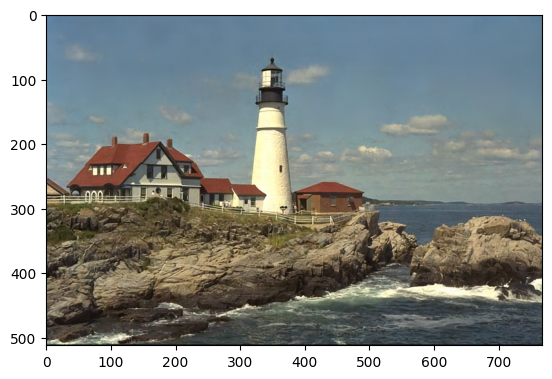

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/kaggle/working/decompressed_kodim21.png')
imgplot = plt.imshow(img)

In [7]:
if __name__ == "__main__":
    print(torch.cuda.is_available())
    main(data='/kaggle/input/oxfordpet-100/oxfordpet',output_dir = '/kaggle/working/',cuda=True, clip_max_norm=1.0, checkpoint='/kaggle/working/0.05checkpoint_best.pth.tar', real=False)


True
Loading /kaggle/working/0.05checkpoint_best.pth.tar
average_PSNR: 31.18dB
average_MS-SSIM: 16.9828
average_Bit-rate: 1.033 bpp
average_time: 0.321 ms
